<a href="https://colab.research.google.com/github/sharmin133/Rice-Leaf/blob/main/vgg19%2Bcanny%2Bclahe_final_1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.applications import VGG19

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 45
CHANNELS=3
EPOCHS=25

In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/Final Thesis/Feature Extraction/Canny edge detection/CLAHE+canny",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7471 files belonging to 5 classes.


In [ ]:
class_names= dataset.class_names
print(class_names)
len(dataset)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro', '_Healthy']


117

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 45, 45, 3)
[2 2 4 0 4 1 2 3 3 4 2 0 1 1 1 2 0 3 3 2 4 2 2 3 4 1 4 4 3 4 1 2 4 3 0 0 0
 2 3 4 1 2 3 4 1 2 2 3 0 3 1 3 0 0 4 1 2 4 0 4 2 0 3 4]


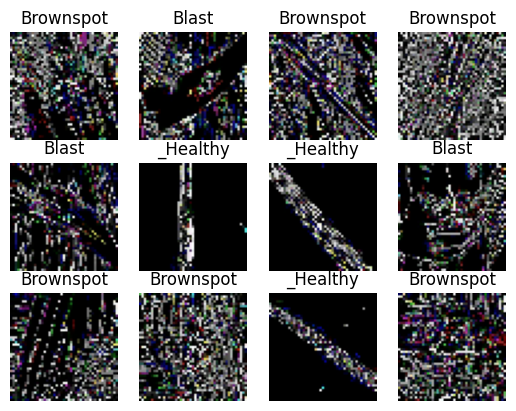

In [ ]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split +  val_split+test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds,test_ds= get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

81
11
25


In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:

n_classes = len(class_names)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

model = Sequential()
model.add(base_model)
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 20057541 (76.51 MB)
Trainable params: 33157 (129.52 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,

    epochs=25,
)

Epoch 1/25
163/163 [==============================] - 186s 1s/step - loss: 0.6237 - accuracy: 0.7236 - val_loss: 0.5169 - val_accuracy: 0.7872
Epoch 2/25
163/163 [==============================] - 163s 1s/step - loss: 0.6091 - accuracy: 0.7265 - val_loss: 0.5450 - val_accuracy: 0.7844
Epoch 3/25
163/163 [==============================] - 160s 986ms/step - loss: 0.6072 - accuracy: 0.7274 - val_loss: 0.5081 - val_accuracy: 0.8095
Epoch 4/25
163/163 [==============================] - 163s 999ms/step - loss: 0.6105 - accuracy: 0.7265 - val_loss: 0.5210 - val_accuracy: 0.8067
Epoch 5/25
163/163 [==============================] - 161s 986ms/step - loss: 0.6021 - accuracy: 0.7311 - val_loss: 0.5361 - val_accuracy: 0.7872
Epoch 6/25
163/163 [==============================] - 181s 1s/step - loss: 0.5859 - accuracy: 0.7346 - val_loss: 0.5091 - val_accuracy: 0.7955
Epoch 7/25
163/163 [==============================] - 164s 1s/step - loss: 0.5865 - accuracy: 0.7349 - val_loss: 0.5141 - val_accurac

In [ ]:
scores = model.evaluate(test_ds)

48/48 [==============================] - 71s 866ms/step - loss: 0.4272 - accuracy: 0.8424


In [ ]:
scores

[0.4271535575389862, 0.8424479365348816]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

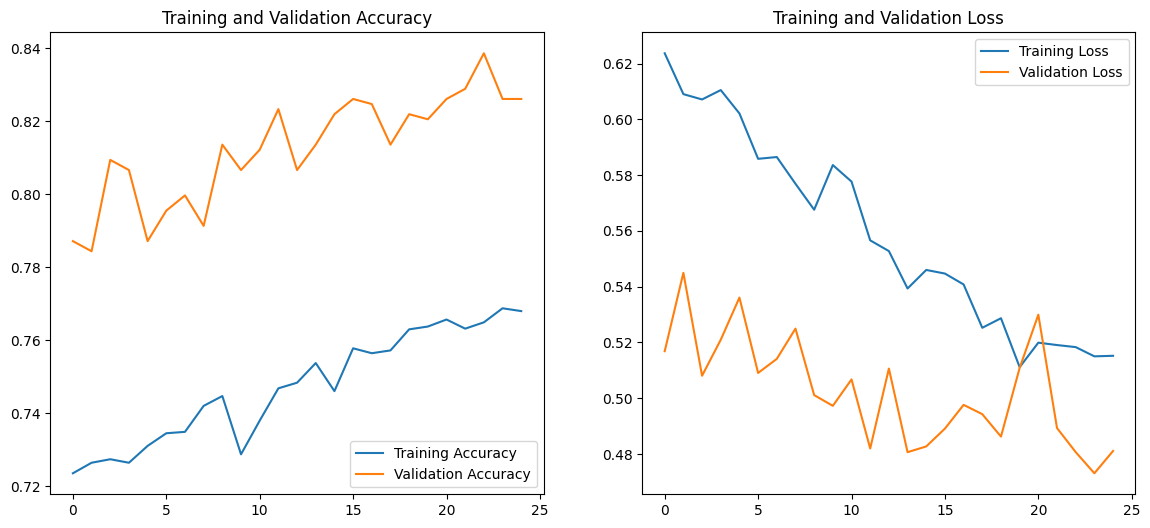

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tungro
1/1 [==============================] - 1s 995ms/step
predicted label: Tungro


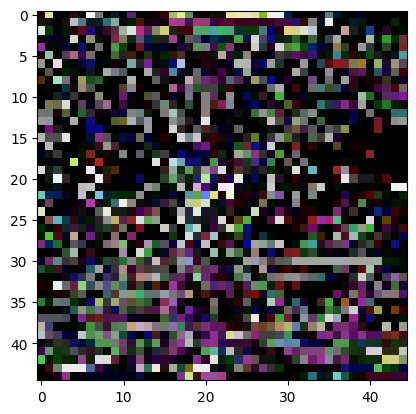

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

48/48 [==============================] - 44s 911ms/step


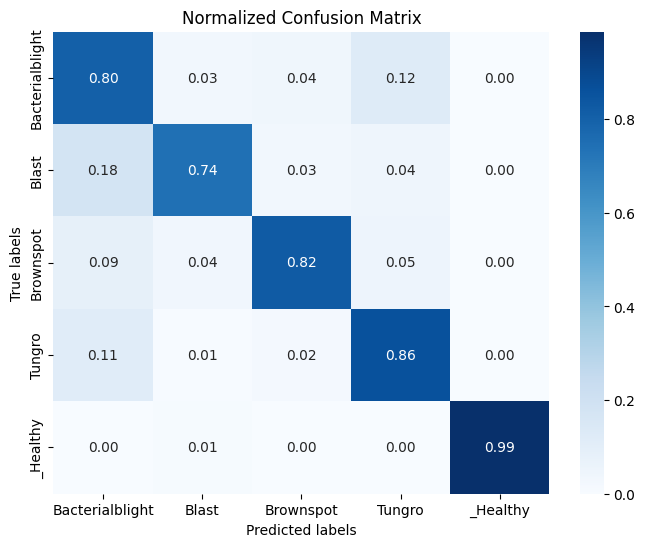

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
predicted_labels = np.argmax(model.predict(test_images), axis=-1)
cm = confusion_matrix(test_labels, predicted_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = class_names
report = classification_report(test_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       0.70      0.80      0.75       328
          Blast       0.89      0.74      0.81       291
      Brownspot       0.90      0.82      0.86       322
         Tungro       0.78      0.86      0.82       293
       _Healthy       1.00      0.99      0.99       302

       accuracy                           0.84      1536
      macro avg       0.85      0.84      0.85      1536
   weighted avg       0.85      0.84      0.84      1536

